# Battery cell lifetime predictions
This notebook demonstrates a simple battery lifetime simulation script used in the Battery Estimation and Early Prediction (beep) framework.
This notebook shows a dataset generated by a the simulator, and demonstrates how additional "experiments" can be performed using the same simulator.

## Background
In a publication by Attia et al., the simulator was used to assist in optimal experiment design (OED) to determine cycling protocols that result in longer lifetimes of battery cells. From the article: 
> The cells were cycled with various charging protocols but identically
discharged. Cells were charged with one of 224 candidate six-step, ten-
minute charging protocols from 0% to 80% SOC, as detailed below. After
a five-second rest, all cells then charged from 80% to 100% SOC with
a 1C CC-CV charging step to 3.6 V and a current cutoff of C/20. After
another five-second rest, all cells subsequently discharged with a CC-CV
discharge at 4C to 2.0 V and a current cutoff of C/20. The cells rested
for another five seconds before the subsequent charging step started.
The lower and upper cutoff voltages were 2.0 V and 3.6 V, respectively,
as recommended by the manufacturer. In this work, cycle life is defined
as the number of cycles until the discharge capacity falls below 80% of
the nominal capacity.


## The simulator
The cell lifetime simulator predicts the lifetime of battery cells undergoing a cycling policy that has four variable cycle steps. The four steps have variable C-rates labeled "CC1", "CC2", "CC3", and "CC4". The steps are timed so that the state of charge (SOC) changes by the same amount for each step. Using default parameters, the 4 steps are all completed within 10 minutes, and a cell is considered fully charged at 80\% capacity (each step incrementing the SOC by 20\% of the full cell capacity).

## Possible tasks during the hackathon...
- Use agents to optimize or investigate correlations between lifetime, charge time, cell size, ...
- Update the simulator for more flexible charging policies

## References
- Attia, P.M., Grover, A., Jin, N. et al. Closed-loop optimization of fast-charging protocols for batteries with machine learning. Nature 578, 397–402 (2020). https://doi.org/10.1038/s41586-020-1994-5  
- https://github.com/TRI-AMDD/beep  

# Load packages and files

In [1]:
%matplotlib inline
import os
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from battery_lifetime_sim import sim

In [2]:
sim_csv = 'beep_simulated_data.csv'

In [3]:
def hook(t):
  def inner(bytes_amount):
    t.update(bytes_amount)
  return inner

#session = boto3.session.Session(profile_name='hack2020')
s3 = boto3.client('s3')
filesize = boto3.resource('s3').Object('hackathon2020-prod', 'data/' + sim_csv).content_length
with tqdm(total=filesize, unit='B', unit_scale=True, desc=sim_csv) as t:
    s3.download_file('hackathon2020-prod', 'data/' + sim_csv, sim_csv, Callback=hook(t))

beep_simulated_data.csv: 100%|██████████| 3.68k/3.68k [00:00<00:00, 5.36kB/s]


# Load data into dataframe and visualize

Load the dataframe. The dataset containst 224 entries with different values of CC1, CC2, and CC3, as the associated simulated lifetime. CC4 is completely determined by the contraints of this specific protocol:
 - the total time to charge is 10 minutes
 - each step adds 20% to the state of charge
 
CC1 ... CC4 are the rates at which the cells are being charged, relative to maximum capacity. So when the rate is 1C (indicated in the dataframe as simply "1"), a cell is fully charged in an hour, and when the rate is 6C ("6"), a single cell is fully charged in 10 minutes. The predicted "sim_life" is the lifetime in number of cycles.

In [4]:
sim_df = pd.read_csv(sim_csv)
sim_df.shape

(224, 4)

The charging protocols in this dataframe match the space studied by Attia et al.

,CC1,CC2,CC3,sim_life
0,7.0,6.0,5.2,458
1,8.0,7.0,5.2,470
2,8.0,6.0,4.0,482
3,8.0,5.6,4.4,487
4,8.0,7.0,3.6,493


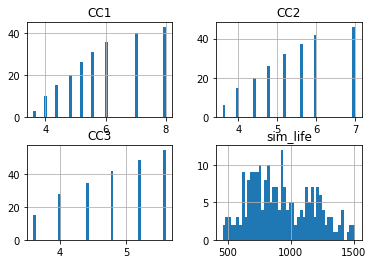

In [5]:
sim_df.hist(bins=48)
sim_df.head()

# Use simulator for new "experiments"

In addition to using the existing dataset, you can also use the simulator to make new predictions. In this cell, we keep the default settings (10 minute time limit and 80% max charge) and predict a new lifetime when CC1=CC2=CC3=100.

In [6]:
sim(100, 100, 100)

546

Here we plot how the predicted lifetime changes over a range of CC1 values, keeping CC2 and CC3 fixed.

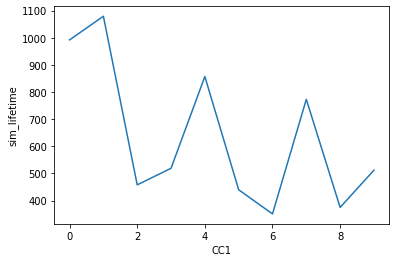

In [7]:
lifetimes = []
for i in range(5, 15):
    lifetimes.append(sim(i, 6, 5.2))
plt.xlabel('CC1')
plt.ylabel('sim_lifetime')
_ = plt.plot(list(range(10)), lifetimes)

In the above examples, batch variation is incorporated via random sampling. We get deterministic results only because we are always setting the same default random seed (set to 0). Now, to demonstrate batch variations over the same charging policy, we instead set ``seed`` to ``None``, which allows the random sampling to change with each call.

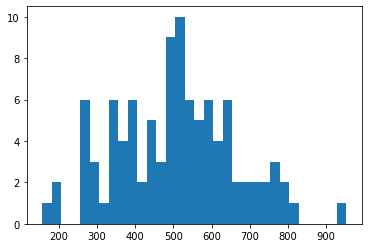

In [8]:
lifetimes = []
for i in range(100):
    lifetimes.append(sim(10, 20, 30, seed=None))
_ = plt.hist(lifetimes, bins=32)

At the other extreme, all randomness can be turned off by decreasing the variance ``sigma`` to zero.

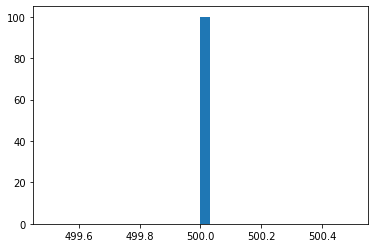

In [9]:
lifetimes = []
for i in range(100):
    lifetimes.append(sim(10, 20, 30, seed=None, sigma=0))
_ = plt.hist(lifetimes, bins=32)

How do lifetimes over a range of CC1 look without batch variations set to zero?

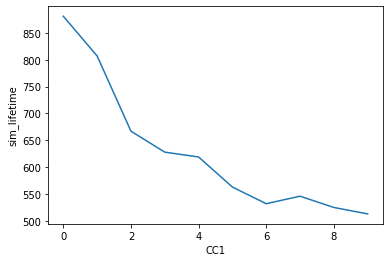

In [10]:
lifetimes = []
for i in range(5, 15):
    lifetimes.append(sim(i, 6, 5.2, sigma=0))
plt.xlabel('CC1')
plt.ylabel('sim_lifetime')
_ = plt.plot(list(range(10)), lifetimes)